In [1]:
import numpy as np
import matplotlib.pyplot as plt

from helper_functions import *


This is a 2D representation of an environment. Your objective is to use the included functions in the provided helper_functions.file to define the goal and avoid sets. The generate results should look like this. The green circle is centered on $x_g = [1.5, 1]$ and has a radius of 0.3, and the the red ellipse has a center at $x_a = [1, 0]$. The axis have length $1$ and $0.4$ respectively and is rotated $45 \degree$

![title](.Pics/Desired_look.png.png)

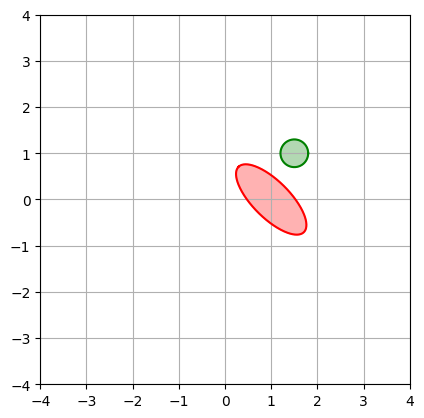

In [2]:
#Insert your code here:
#===================================
x_gc = np.array([1.5, 1])
x_ac = np.array([1,0])

r_g = 0.3

r_ax = 1
r_ay = 0.4

rotation_a = 3*np.pi/4

gx, gy = ellipse(x_gc, r_g)
ax, ay = ellipse(x_ac, r_ax, r_ay, theta=rotation_a)
#===================================

#Give the Avoid set and goal set. Use this function to plot it.

visualize_env(gx, gy, ax, ay)


In the lecture, we saw that solving the Hamilton–Jacobi–Isaacs (HJI) PDE:

$\partial_t V + \min_u \max_d \nabla V \cdot f(x,u,d) = 0$ 
 
lets us compute backward reachable sets. The Level-set method solves this PDE on a discretized grid.

Let's discretize the environment and compare it to how the real enviornment looks like. To do this we need to define how fine our grid abstraction needs to be. The coarsness of the abstraction can be selected by choosing different values for $N$. Try different values for $N$ and see how it impacts how similar the discretized representation is to the actual shapes. What are the benefits and drawbacks of using different levels of abstraction?

For the plotting we use the signed distance function to decide if the discretized points are inside or outside the set.

Use the below code to see how the represenation changes with the level of discretization. Start with $N=25$ and go up from there

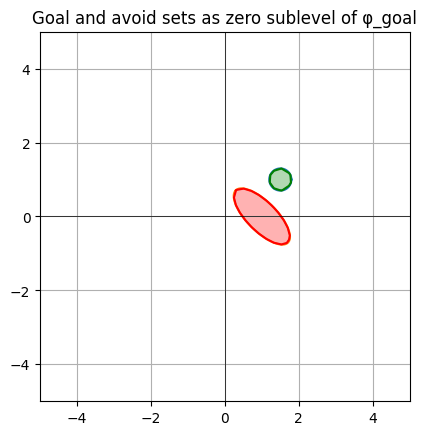

In [3]:
#Discretize the system and show the approximated dynamcis
# Try different values for N
N = 50



# Creating the discretized grid
xlim = ylim = (-5.0, 5.0)
xs = np.linspace(*xlim, N)
ys = np.linspace(*ylim, N)
X, Y = np.meshgrid(xs, ys, indexing='ij')
dx = xs[1] - xs[0]

#Creating the sets
phi_goal = sdf_ellipse(X, Y, x_gc, r_g)
phi_avoid = sdf_ellipse(X,Y, x_ac, r_ax, r_ay, rotation_a)

goal_mask = phi_goal <= 0
avoid_mask = phi_avoid <= 0

#plot goal
plt.plot(gx,gy)
#plot aboid
plt.plot(ax,ay)

#Plot discretized goal and avoid sets
plt.contour(X, Y, phi_goal, levels=[0], colors='g')  # boundary
plt.contourf(X, Y, phi_goal, levels=[phi_goal.min(), 0], alpha=0.3, colors=['green'])

plt.contour(X, Y, phi_avoid, levels=[0], colors='r')  # boundary
plt.contourf(X, Y, phi_avoid, levels=[phi_avoid.min(), 0], alpha=0.3, colors=['red'])

plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.gca().set_aspect('equal')
plt.title("Goal and avoid sets as zero sublevel of φ_goal")
plt.grid()

We can see that this discretization is an under approximation of both the reach and avoid sets. One of them should be over approximated, why? Provide a simple fix that makes it an over approximation and plot the results.

When implementing this fix, keep in mind that we have already caluclated a level set. Think about what the level set represents and what it indicates. The fix can be implemented using one simple operation

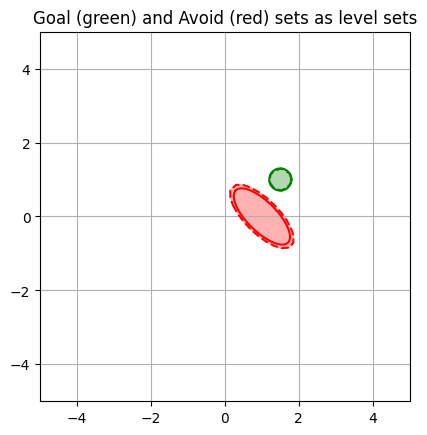

In [4]:
phi_avoid = phi_avoid-dx/np.sqrt(2)

#phi_avoid = np.min([sdf_ellipse(X, Y, x_ac, r_ax,r_ay, rotation_a)-dx/2, sdf_ellipse(X, Y, x_ac-1, r_ax,r_ay, rotation_a)-dx/2],axis=0)



avoid_mask = phi_avoid <= 0

plt.plot(ax,ay, color='r')
plt.plot(gx,gy, color='g')

plt.contour(X, Y, phi_goal, levels=[0], colors='g', linestyles='--')
plt.contourf(X, Y, phi_goal, levels=[phi_goal.min(), 0], alpha=0.3, colors=['green'])


plt.contour(X, Y, phi_avoid, levels=[0], colors='r', linestyles='--')
plt.contourf(X, Y, phi_avoid, levels=[phi_avoid.min(), 0], alpha=0.3, colors=['red'])

plt.gca().set_aspect('equal')
plt.title("Goal (green) and Avoid (red) sets as level sets")
plt.grid()

## Solving the Hamilton–Jacobi–Isaacs PDE

We now have a correct abstraction of the reach and avoid sets, including appropriate over- and under-approximations.  
In this section, we will solve the Hamilton–Jacobi–Isaacs (HJI) partial differential equation introduced in the lectures using the level-set method.

## Upwind approximation of the spatial gradient

To evaluate the HJI PDE numerically, we need the spatial gradient $ \nabla V(t,x) $. On a grid, we approximate derivatives using finite differences.

In the HJI equation,
$
\frac{\partial V(t,x)}{\partial t} \;+\; \min_{u}\max_{d}\;\nabla V(t,x)\cdot f(x,u,d) \;=\; 0,
\qquad V(T,x)=l(x),
$

the term $\nabla V(t,x)\cdot f(x,u,d)$ is the directional derivative of $V$ along the dynamics.  
This is the quantity that determines how the value function propagates through the state space.

In our setting, we use dynamics of the form
$
\dot{x} = f(x,u,d) = F(x) + u + d,
$
where $F(x)$ is a known drift (e.g., a flow field), and $u$ and $d$ are bounded control and disturbance inputs.

---

## The Hamiltonian for reachability with drift $F(x)$

We define $p = \nabla V = (p_x, p_y)$.  
The Hamiltonian is the result of solving the inner min–max problem in the PDE:

$
H(x,p) \;=\; \min_{u}\max_{d}\; p^\top \big(F(x)+u+d\big).
$

This can be decomposed into two parts:

1. Drift contribution (what the environment does):
$
p^\top F(x) = p_x F_x(x) + p_y F_y(x).
$

2. Control/disturbance game contribution (best vs worst within bounds):
$
\min_{u}\max_{d}\; p^\top(u+d) \;=\; (d_{\max}-u_{\max})\left(|p_x|+|p_y|\right).
$

Putting these together gives:
$
H(x,p) \;=\; p^\top F(x) \;+\; (d_{\max}-u_{\max})\left(|p_x|+|p_y|\right).
$

### Task: Hamiltonian implementation

Implement the function:

```python
def hamiltonian_reach(px, py, F_x, F_y, u_max, d_max):
    return p_dot_F + mag_term

In [5]:
u_max = 0.6
d_max = 0.3


def hamiltonian(px, py, F_x, F_y, u_max, d_max):
    p_dot_F = px * F_x + py * F_y
    mag_term = (d_max - u_max) * (np.abs(px) + np.abs(py))

    return p_dot_F + mag_term

## Upwind finite differences (why we need them)

To evaluate the HJI PDE numerically, we must approximate the spatial gradient  
$\nabla V(t,x)$ on a discrete grid.

Recall that the HJI equation has the form
$
\frac{\partial V(t,x)}{\partial t}
\;+\;
\min_{u}\max_{d}\;\nabla V(t,x)\cdot f(x,u,d)
\;=\; 0,
$
which is a first-order nonlinear partial differential equation.

For such equations, information propagates along characteristic directions determined by the dynamics.  
Using a naive central-difference approximation of the gradient may cause information to propagate in the wrong direction, leading to numerical instability and incorrect reachable sets.

To avoid this, we use an upwind finite-difference scheme, which explicitly accounts for the direction of propagation.

---

## One-sided finite differences on a grid

Let $V[i,j]$ denote the value function at the grid point $(x_i,y_j)$, and let $\Delta x$ be the grid spacing.

We define the following one-sided finite differences:

Forward differences
$
D_x^+ V[i,j] = \frac{V[i+1,j] - V[i,j]}{\Delta x},
\qquad
D_y^+ V[i,j] = \frac{V[i,j+1] - V[i,j]}{\Delta x}.
$

Backward differences
$
D_x^- V[i,j] = \frac{V[i,j] - V[i-1,j]}{\Delta x},
\qquad
D_y^- V[i,j] = \frac{V[i,j] - V[i,j-1]}{\Delta x}.
$

Each of these approximates the same derivative, but using information from different neighboring grid points.

---

## Upwind selection rule

The upwind approximation selects which one-sided derivative should contribute to the gradient based on the local direction of propagation.

In this lab, we use the following upwind selection rule:
$
p_x \approx \max(D_x^- V, 0) + \min(D_x^+ V, 0),
$
$
p_y \approx \max(D_y^- V, 0) + \min(D_y^+ V, 0).
$

This can be interpreted as follows:
- If the derivative is locally positive, the backward difference contributes.
- If the derivative is locally negative, the forward difference contributes.

This Godunov-style scheme ensures that the numerical approximation respects the direction in which information propagates, leading to stable and physically meaningful solutions of the HJI equation.

---

## Task: Upwind gradient implementation

Implement the function

```python
def grad_upwind(V, dx):
    return px, py

In [6]:
def grad_upwind(V, dx):
    Vx_f = (np.roll(V, -1, axis=0) - V) / dx
    Vx_b = (V - np.roll(V, 1, axis=0)) / dx
    Vy_f = (np.roll(V, -1, axis=1) - V) / dx
    Vy_b = (V - np.roll(V, 1, axis=1)) / dx

    # One simple choice: take the upwind magnitude per dimension
    px_pos = np.maximum(Vx_b, 0.0)  # flow to the right
    px_neg = np.minimum(Vx_f, 0.0)  # flow to the left
    py_pos = np.maximum(Vy_b, 0.0)  # flow to the top
    py_neg = np.minimum(Vy_f, 0.0)  # flow to the bottom

    px = px_pos + px_neg
    py = py_pos + py_neg
    return px, py

In [7]:
omega = 0.8  # angular speed; play with this

def drift_field(X, Y, omega):
    F_x = -omega * Y
    F_y =  omega * X
    return F_x, F_y

F_x, F_y = drift_field(X, Y, omega)

## Drift field and time discretization

In the HJI equation, the Hamiltonian depends not only on the control and disturbance inputs, but also on the drift term $F(x)$ appearing in the system dynamics
$
\dot{x} = F(x) + u + d.
$

In this lab, we consider a linear drift field of the form
$
F(x) = A x,
\qquad
A =
\begin{pmatrix}
1 & -1 \\
1 & -1
\end{pmatrix}.
$

This drift field defines how the environment evolves in the absence of control and disturbance.  
To use it in the Hamiltonian, we must evaluate $F(x)$ at every grid point.

---

### Task: Evaluate the drift field on the grid

The arrays `X` and `Y` contain the coordinates of all grid points.  
Your task is to compute two arrays:

- `F_x`, containing the first component of $F(x)$ evaluated at each grid point
- `F_y`, containing the second component of $F(x)$ evaluated at each grid point

These arrays must have the same shape as `X` and `Y`, so they can be used in elementwise operations when evaluating the Hamiltonian.

---

### Time step selection (CFL condition)

After computing the drift field, we choose a time step size $\Delta t$ for the numerical solver.

The HJI equation is solved using an explicit time-stepping scheme, which requires the time step to satisfy a Courant–Friedrichs–Lewy (CFL) condition to ensure numerical stability.

To this end:
- we estimate the maximum speed induced by the drift field,
- we account for the additional speed introduced by control and disturbance,
- and we scale the time step proportionally to the grid spacing $\Delta x$.

This ensures that information does not propagate across more than one grid cell per time step.

The resulting time step $\Delta t$ determines how many backward propagation steps are required to reach the initial time.


If implemented correctly you should have a dt of about $0.0099$ and $num_steps = 201$ if $N = 50$

In [8]:
A = np.array([[1, -1],
              [1, -1]])


# Implement this:
# ==================================================================
F_x = A[0,0] * X + A[0,1] * Y
F_y = A[1,0] * X + A[1,1] * Y
# ==================================================================


# Do not touch this:
F_inf = np.max(np.maximum(np.abs(F_x), np.abs(F_y)))
speed = F_inf + abs(u_max - d_max) + 1e-8
cfl = 0.5
dt  = cfl * dx / speed
T = 2.0
num_steps = int(T / dt)
print("dt =", dt, "num_steps =", num_steps)

dt = 0.00990687536188949 num_steps = 201


## Backward propagation of the value function

We are now ready to propagate the value function backward in time by solving the HJI PDE on the grid.

In reach–avoid problems, the terminal value function $V(T,x)$ must encode both:
- the goal set (states we want to reach), and
- the avoid set (states we must not enter).

Using level-set representations $\phi_{\text{goal}}(x)$ and $\phi_{\text{avoid}}(x)$, we construct the terminal condition as

$
V(T,x) = \max\big(\phi_{\text{goal}}(x),\; -\phi_{\text{avoid}}(x)\big).
$

Interpretation:
- $\phi_{\text{goal}}(x) \le 0$ inside the goal (desired).
- $\phi_{\text{avoid}}(x) \le 0$ inside the avoid set (unsafe), so $-\phi_{\text{avoid}}(x)$ is positive there.
- Taking the maximum ensures that states inside the avoid set are assigned a positive value (unsafe), even if they are close to the goal.

---

### Discretizing the PDE in time

Recall the HJI PDE form (final-value problem):

$
\frac{\partial V}{\partial t} + H(x, \nabla V) = 0,
\qquad V(T,x) = l(x).
$

To propagate backward from time $T$ to time $0$, we use a simple explicit Euler discretization in time.  
At each time step, we evaluate the Hamiltonian using the current gradient approximation and update the value function as

$
V(t-\Delta t, x) \approx V(t,x) + \Delta t \, H(x, \nabla V(t,x)).
$

This update is computed pointwise on the grid.

---

### Enforcing the avoid constraint (reach–avoid coupling)

In a reach–avoid problem, the value function must respect the fact that entering the avoid set is not allowed.  
After each Euler update, we enforce the avoid constraint by projecting the updated value function back onto the admissible set using

$
V(t-\Delta t, x) \leftarrow \max\big(V(t-\Delta t, x),\; -\phi_{\text{avoid}}(x)\big).
$

This ensures that states inside the inflated avoid set remain “unsafe” in the value function representation.

---

### Task

You are given the full solver loop below. Your task is to implement the three key lines:

1. The explicit Euler backward update  
   Compute the new value function using the Hamiltonian.

2. The reach–avoid constraint enforcement step  
   Enforce that the value function does not become smaller than $-\phi_{\text{avoid}}$ inside the inflated avoid set.

3. Save the newly obtained V in the Vs array.

These three operations are the core of the numerical PDE solver.

In [9]:
V_T = np.maximum(phi_goal, -phi_avoid)  # this is V at t = T

px, py = grad_upwind(V_T,dx)


N = X.shape[0]  # assuming square grid
Vs = np.zeros((num_steps + 1, N, N))

# t = T slice
Vs[0] = V_T.copy()

V = V_T.copy()

for k in range(num_steps):
    px, py = grad_upwind(V, dx)
    H = hamiltonian(px, py, F_x, F_y, u_max, d_max)

    # Implement code here:
    # =================================
    V_t = V + dt * H #Step back in time
    V = np.maximum(V_t, -phi_avoid) #Enforce constraints
    Vs[k+1] = V # Save the newly obtained V
    # =================================

If implemented correctly, you can use the below code to slide through the different time steps and see how the reachable set changes over time

In [10]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

@interact(k=IntSlider(min=0, max=num_steps, step=1, value=0))
def show_level_set(k):
    plt.figure(figsize=(5,5))
    V_k = Vs[k]

    # Zero level set of V
    cs = plt.contour(X, Y, V_k, levels=[0], colors='b', linewidths=2)
    plt.clabel(cs, fmt={0: 'BRS'}, inline=True, fontsize=8)

    # Goal and avoid (inflated) boundaries for reference
    plt.contour(X, Y, phi_goal, levels=[0], colors='g', linestyles='--')
    plt.contour(X, Y, phi_avoid, levels=[0], colors='r', linestyles='--')

    plt.gca().set_aspect('equal')
    plt.title(f"Backward level set, step {k}/{num_steps}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.show()

interactive(children=(IntSlider(value=0, description='k', max=201), Output()), _dom_classes=('widget-interact'…

## Adding state-dependent dynamics: a rotational drift field

So far, we have propagated the value function backward in time and observed how the zero level set evolves.  
This demonstrates the core idea of backward reachability, but the dynamics we used were relatively simple and may produce level-set evolution that looks “too symmetric” or visually uninteresting.

What happens if the system dynamics depend on the current state $x$?

---

Recall that we model the dynamics as
$
\dot{x} = F(x) + u + d,
$
where:
- $F(x)$ is a drift term (environment / passive dynamics),
- $u$ is the control input,
- $d$ is the disturbance.

Previously, $F(x)$ was either zero or constant.  
We now replace it with a rotational vector field (a “vortex”) around the origin:

$
F(x,y) =
\begin{pmatrix}
-\omega y \\
\;\;\omega x
\end{pmatrix}.
$

Interpretation:
- The drift makes the state rotate counterclockwise around the origin.
- The parameter $\omega$ controls how fast the rotation is.

---

### What changes in the solver?

Nothing in the HJI solver changes structurally:  
you still compute $\nabla V$, evaluate the Hamiltonian $H(x,\nabla V)$, and step backward in time.

The only difference is that the Hamiltonian now uses a state-dependent drift field $F(x)$, meaning the term $p^\top F(x)$ varies across the grid.

Because the drift magnitude changes, we also recompute the time step $\Delta t$ using the CFL condition.

---

### Task

Run the cell below to define the rotational drift field and compute its values on the grid.  
Then redo the backward propagation in time using the same solver loop as before.

As you change $\omega$, observe how the reachable set evolves:
- Does it expand symmetrically?
- Does it “bend” or “twist” due to the flow field?
- How does increasing $\omega$ change the reachable set?

In [11]:
omega = 0.8  # angular speed, play with it

def drift_field(X, Y, omega):
    F_x = -omega * Y
    F_y =  omega * X
    return F_x, F_y

F_x, F_y = drift_field(X, Y, omega)

F_inf = np.max(np.maximum(np.abs(F_x), np.abs(F_y)))
speed = F_inf + abs(u_max - d_max) + 1e-8
cfl = 0.5
dt  = cfl * dx / speed
T = 2.0
num_steps = int(T / dt)

## Avoid tube: Hamiltonian and backward propagation

In addition to the reach set, we also want to compute the **avoid tube**: the set of states from which the system can be forced into the avoid set within the remaining time horizon.

We use the same dynamics model as before,
$
\dot{x} = F(x) + u + d,
$
but now we interpret the game differently:

- for the **reach** problem, the controller is trying to reach the goal despite worst-case disturbances,
- for the **avoid** problem, we compute when entering the avoid set becomes unavoidable (the disturbance acts as an adversary, while the controller attempts to prevent entry).

As a result, the avoid tube satisfies its own HJI equation with a Hamiltonian that differs from the reach case.

---

## Avoid Hamiltonian

Let $p = \nabla V = (p_x, p_y)$. The Hamiltonian always contains the drift contribution
$
p^\top F(x) = p_x F_x(x) + p_y F_y(x).
$

For the avoid problem, the control and disturbance roles are reversed compared to the reach case, which changes the sign of the “game-in-the-magnitude” term. In this lab we use

$
H_{\text{avoid}}(x,p)=p^\top F(x)+(u_{\max} - d_{\max})\left(|p_x| + |p_y|\right).
$

### Task

Implement the function

```python
def hamiltonian_avoid(px, py, F_x, F_y, u_max, d_max):

In [12]:
def hamiltonian_avoid(px, py, F_x, F_y, u_max, d_max):
    """
    H_avoid(x,p) = p^T F(x) + (u_max - d_max) * ||p||_1
    """
    p_dot_F = px * F_x + py * F_y
    #mag_term = (d_max - u_max) * (np.abs(px) + np.abs(py))
    mag_term = (u_max - d_max) * (np.abs(px) + np.abs(py))
    return p_dot_F + mag_term


N = X.shape[0]
Vs_reach = np.zeros((num_steps + 1, N, N))
Vs_avoid = np.zeros((num_steps + 1, N, N))

# Terminal conditions at t = T
V_reach = phi_goal.copy()
V_avoid = phi_avoid.copy()

Vs_reach[0] = V_reach
Vs_avoid[0] = V_avoid


for k in range(num_steps):
    px_r, py_r = grad_upwind(V_reach, dx)
    px_a, py_a = grad_upwind(V_avoid, dx)

    H_reach = hamiltonian(px_r, py_r, F_x, F_y, u_max, d_max)
    H_avoid = hamiltonian_avoid(px_a, py_a, F_x, F_y, u_max, d_max)

    # Copy paste the euler step, intersection, and saving from previous section
    V_reach = V_reach + dt * H_reach
    V_avoid_new = V_avoid + dt * H_avoid


    V_reach = np.maximum(V_reach, -phi_avoid)
    V_avoid = np.minimum(V_avoid, V_avoid_new)

    # Compare the backpropagated reach and avoid sets.
    V_reach = np.maximum(V_reach, -V_avoid)


    Vs_reach[k + 1] = V_reach
    Vs_avoid[k + 1] = V_avoid

In [13]:
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

@interact(k=IntSlider(min=0, max=num_steps, step=1, value=0))
def show_reach_and_avoid(k):
    plt.figure(figsize=(6,6))
    
    V_r = Vs_reach[k]    # from your reach solver
    V_a = Vs_avoid[k]    # from avoid solver above

    # Reach tube (controller winning) – blue
    plt.contour(X, Y, V_r, levels=[0], colors='b', linewidths=2)

    # Avoid tube (disturbance winning) – orange
    plt.contour(X, Y, V_a, levels=[0], colors='orange', linewidths=2)

    # Goal and obstacle geometry
    plt.contour(X, Y, phi_goal,           levels=[0], colors='g',  linestyles='--')
    plt.contour(X, Y, phi_avoid,     levels=[0], colors='r',  linestyles='--')

    plt.gca().set_aspect('equal')
    plt.xlabel("x"); plt.ylabel("y")
    plt.title(f"Reach tube (blue) vs Avoid tube (orange), step {k}/{num_steps}")
    plt.show()

interactive(children=(IntSlider(value=0, description='k', max=84), Output()), _dom_classes=('widget-interact',…

This is just a similar thing again but with a video element for the fun of it

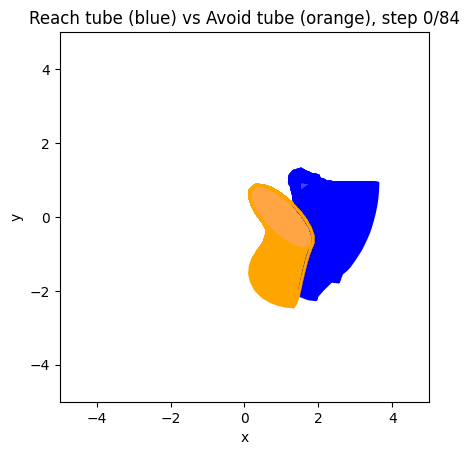

In [14]:
from IPython.display import HTML
animation = animate(Vs_reach, Vs_avoid, X, Y, phi_goal, phi_avoid, num_steps)
HTML(animation.to_jshtml())

NOW WE GO TO C-LEVEL

## Scaling experiment: why grid-based HJ reachability breaks in higher dimensions

In the previous parts of the lab, you implemented the core numerical building blocks for a grid-based HJI solver:
- an upwind approximation of the spatial gradient $\nabla V$,
- and a Hamiltonian $H(x,\nabla V)$ that encodes drift, control, and disturbance.

In this section, the goal is **not** to solve a difficult robotics problem, but to quantify *why the method becomes impractical as the state dimension increases*.

You will:
1. generalize your implementation to $d$ dimensions,
2. measure runtime and memory usage,
3. and produce a graph showing how both scale with dimension.

---

## Background: what causes the scaling problem?

### Grid size grows exponentially

If we discretize each state dimension using $N$ grid points, then the total number of grid points is

$
|\mathcal{G}| = N^d.
$

Even for modest $N$, this grows extremely fast with dimension $d$.  
Since the value function $V$ must be stored at every grid point, the memory required to store a single array scales as

$
\text{memory}(V) \propto N^d.
$

### Each PDE step is also $O(N^d)$

In every backward time step, you compute:
- an upwind gradient along every dimension,
- and the Hamiltonian,
- and then update the value function.

All of these operations are done at every grid point, so the computational work per step also scales as

$
\text{time per step} \propto N^d.
$

This is the **curse of dimensionality** for grid-based dynamic programming / HJ reachability.

---

## What you will implement

### (A) N-D upwind gradient

In 2D you implemented:
$
p_x \approx \max(D_x^-V, 0) + \min(D_x^+V, 0),
\qquad
p_y \approx \max(D_y^-V, 0) + \min(D_y^+V, 0).
$

In $d$ dimensions, you will implement the same idea along each coordinate axis:

- For each dimension $i \in \{1,\dots,d\}$, compute forward and backward differences $D_i^+V$ and $D_i^-V$.
- Construct $p_i$ using the same upwind selection rule.

Your function should return a list (or tuple) of $d$ arrays:
$
(p_1, p_2, \dots, p_d).
$

### (B) N-D Hamiltonian

In 2D with drift field $F(x)=(F_x,F_y)$, we used:
$
H(x,p) = p^\top F(x) + (d_{\max}-u_{\max})\sum_{i=1}^d |p_i|.
$

In $d$ dimensions, this becomes:
$
H(x,p) = \sum_{i=1}^d p_i F_i(x) \;+\; (d_{\max}-u_{\max})\sum_{i=1}^d |p_i|.
$

Here $F(x)\in\mathbb{R}^d$ is the drift field evaluated on the grid (you can choose a simple drift for the scaling experiment).

---

## Scaling task

### Goal

Create a plot of:
- **runtime per PDE step** vs. dimension $d$,
- **memory usage** vs. dimension $d$,

for a fixed number of grid points per dimension $N$.

### Suggested experiment

Choose:
- a fixed $N$ (e.g., $N=21$ or $N=31$),
- a set of dimensions $d \in \{2,3,4,5,6\}$ (stop earlier if it becomes too large),
- and a small number of backward steps (e.g., 1–5 steps).

For each dimension $d$:
1. allocate $V \in \mathbb{R}^{N \times \dots \times N}$,
2. run a small number of backward update steps,
3. measure:
   - **peak memory** used by the main arrays,
   - **time per step** for the loop.

Your final output for this section should be a plot showing time and memory versus $d$.

---

## Reflection questions (answer in your report)

1. **Exponential growth:**  
   For your chosen $N$, how does $N^d$ change as you increase $d$ by 1?  
   Relate this to the slope of your memory plot.

2. **Practical limit:**  
   At what dimension $d$ does the method become impractical on your machine?  
   Was the limiting factor memory, runtime, or both?

3. **Algorithmic cost:**  
   Which part of the solver is most expensive as $d$ increases: gradient computation, Hamiltonian evaluation, or storage?  
   Justify based on what operations scale with $d$ and what scales with $N^d$.

4. **Resolution vs. dimension trade-off:**  
   Suppose you want to keep memory fixed while increasing $d$.  
   How would $N$ need to change as a function of $d$?  
   What does this imply about solution quality?

5. **Why alternative methods are needed:**  
   Based on your results, explain why high-dimensional reachability methods (e.g., decomposition or function approximation) are studied as alternatives to grid-based PDE solvers.

---

### Deliverable checklist

- [ ] Your implemented `grad_upwind_nd(...)` and `hamiltonian_nd(...)`
- [ ] A plot of runtime vs. dimension
- [ ] A plot of memory vs. dimension
- [ ] Written answers to the reflection questions above

d=2, N=15, grid points=225, V memory≈0.0 MB, dt=7.519e-02
3 steps took 0.000 s  (avg 0.000 s/step)
d=3, N=15, grid points=3,375, V memory≈0.0 MB, dt=7.519e-02
3 steps took 0.001 s  (avg 0.000 s/step)
d=4, N=15, grid points=50,625, V memory≈0.4 MB, dt=7.519e-02
3 steps took 0.003 s  (avg 0.001 s/step)
d=5, N=15, grid points=759,375, V memory≈5.8 MB, dt=7.519e-02
3 steps took 0.058 s  (avg 0.019 s/step)
d=6, N=15, grid points=11,390,625, V memory≈86.9 MB, dt=7.519e-02
3 steps took 1.073 s  (avg 0.358 s/step)
d=7, N=15, grid points=170,859,375, V memory≈1303.6 MB, dt=7.519e-02
3 steps took 42.654 s  (avg 14.218 s/step)


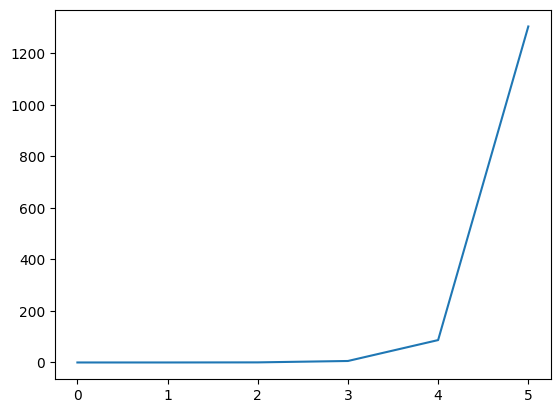

In [ ]:
import numpy as np
import time

def grad_upwind_nd(V, dx):
    #Implement this:
    d = V.ndim
    grads = []
    for axis in range(d):
        Vf = np.zeros_like(V)
        Vb = np.zeros_like(V)

        slc_from = [slice(None)] * d
        slc_to   = [slice(None)] * d
        slc_from[axis] = slice(1, None)
        slc_to[axis]   = slice(None, -1)

        Vf[tuple(slc_to)] = (V[tuple(slc_from)] - V[tuple(slc_to)]) / dx
        slc_last = [slice(None)] * d; slc_last[axis] = -1
        slc_prev = [slice(None)] * d; slc_prev[axis] = -2
        Vf[tuple(slc_last)] = Vf[tuple(slc_prev)]

        Vb[tuple(slc_from)] = (V[tuple(slc_from)] - V[tuple(slc_to)]) / dx
        slc_first = [slice(None)] * d; slc_first[axis] = 0
        slc_next  = [slice(None)] * d; slc_next[axis]  = 1
        Vb[tuple(slc_first)] = Vb[tuple(slc_next)]

        p = np.maximum(Vb, 0.0) + np.minimum(Vf, 0.0)
        grads.append(p)
    return grads

def hamiltonian_reach_nd(grads, F, u_max, d_max):
    #Implement this
    # H = p·F + (d_max - u_max)*||p||_1
    p_dot_F = np.zeros_like(grads[0])
    l1 = np.zeros_like(grads[0])
    for i, p in enumerate(grads):
        p_dot_F += p * F[i]
        l1 += np.abs(p)
    return p_dot_F + (d_max - u_max) * l1

def make_grid(N, d, lim=(-2,2)):
    xs = [np.linspace(lim[0], lim[1], N) for _ in range(d)]
    Xs = np.meshgrid(*xs, indexing="ij")
    dx = xs[0][1] - xs[0][0]
    return Xs, dx

def grid_scaling(d=4, N=25, steps=5, u_max=0.6, d_max=0.3, omega=0.8):
    Xs, dx = make_grid(N, d)
    shape = (N,) * d

    # simple initial V: distance to origin in first 2 dims (cylinder in higher dims)
    V = np.sqrt(Xs[0]**2 + Xs[1]**2) - 0.5

    # Drift field: rotational in dims 0-1, zero elsewhere
    F = [np.zeros(shape) for _ in range(d)]
    F[0] = -omega * Xs[1]
    F[1] =  omega * Xs[0]

    # CFL-ish dt
    F_inf = np.max(np.maximum(np.abs(F[0]), np.abs(F[1])))
    speed = F_inf + abs(u_max - d_max) + 1e-8
    dt = 0.5 * dx / speed

    # Memory estimate
    mem_MB = V.size * V.itemsize / (1024**2)
    print(f"d={d}, N={N}, grid points={V.size:,}, V memory≈{mem_MB:.1f} MB, dt={dt:.3e}")

    # time a few iterations
    t0 = time.time()
    for k in range(steps):
        grads = grad_upwind_nd(V, dx)
        H = hamiltonian_reach_nd(grads, F, u_max, d_max)
        V = V + dt * H
    t1 = time.time()
    print(f"{steps} steps took {t1-t0:.3f} s  (avg {(t1-t0)/steps:.3f} s/step)")
    return V, mem_MB, t1-t0

memory_use = []
time_use = []
for i in range(6):
    V, memory, t_use = grid_scaling(d=i+2, N = 15, steps = 3)
    memory_use.append(memory)
    time_use.append(t_use)

plt.plot(memory_use)

